<a href="https://colab.research.google.com/github/ru2zi/Book_Genre_Classification/blob/main/inception_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)


2.11.0


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")


TF Version:  2.11.0
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


In [ ]:
import pandas as pd
import pandas as pd
import numpy as np
from tqdm import tqdm
import gc

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler

import tokenizers
import transformers
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
df = pd.read_csv("/kaggle/input/jbnu-swuniv-ai/train_data.csv")
df

,id,Filename,Title,label
0,0,1101903236.jpg,The Oz Family Kitchen: More Than 100 Simple an...,"Cookbooks, Food, Wine"
1,1,0804139857.jpg,Living with Intent: My Somewhat Messy Journey ...,Self Help
2,2,0765334798.jpg,Redshirts: A Novel with Three Codas,"Science Fiction, Fantasy"
3,3,0446310786.jpg,To Kill a Mockingbird,"Mystery, Thriller, Suspense"
4,4,1143002598.jpg,Canning and Preserving of Food Products with B...,"Cookbooks, Food, Wine"
...,...,...,...,...
68677,68677,0735582912.jpg,"Casenote Legal Briefs: Family Law, Keyed to Ha...",Law
68678,68678,1433111020.jpg,Communication for Families in Crisis: Theories...,Law
68679,68679,0444853510.jpg,"Fine-line Lithography (Materials processing, t...","Arts, Photography"
68680,68680,1449465447.jpg,Magic Eye 2016 Wall Calendar,Calendars


In [ ]:
unique_values = df['label'].unique().tolist()

In [ ]:
unique_values

['Cookbooks, Food, Wine',
 'Self Help',
 'Science Fiction, Fantasy',
 'Mystery, Thriller, Suspense',
 'Health, Fitness, Dieting',
 'Humor, Entertainment',
 'Religion, Spirituality',
 'Computers, Technology',
 'Reference',
 'Medical Books',
 'Test Preparation',
 'Engineering, Transportation',
 'Childrens Books',
 'Arts, Photography',
 'Science, Math',
 'Parenting, Relationships',
 'Literature, Fiction',
 'Calendars',
 'Sports, Outdoors',
 'Travel',
 'Crafts, Hobbies, Home',
 'Law',
 'Biographies, Memoirs',
 'Education, Teaching']

In [ ]:
import pandas as pd

# Step 1: Determine the number of samples per class
total_samples = 1000
num_classes = 24
samples_per_class = total_samples // num_classes

# Step 2: Split the original dataset into separate dataframes based on class labels
class_dataframes = []
for class_label in unique_values:
    class_df = df[df['label'] == class_label]  # Replace 'class_label' with the actual column name
    class_dataframes.append(class_df)

# Step 4: Create an empty dataframe to store the extracted samples
sample_df = pd.DataFrame()

# Step 5: Extract samples from each class
for class_df in class_dataframes:
    extracted_samples = class_df.head(samples_per_class)
    sample_df = sample_df.append(extracted_samples)

/tmp/ipykernel_34/866014983.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample_df = sample_df.append(extracted_samples)
/tmp/ipykernel_34/866014983.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample_df = sample_df.append(extracted_samples)
/tmp/ipykernel_34/866014983.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample_df = sample_df.append(extracted_samples)
/tmp/ipykernel_34/866014983.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample_df = sample_df.append(extracted_samples)
/tmp/ipykernel_34/866014983.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

In [ ]:
import os
import pandas as pd

data_dir = "/kaggle/input/jbnu-swuniv-ai/train/"

def create_image_path(row):
    return os.path.join(data_dir, row['label'], row['Filename'])

sample_df['image_path'] = sample_df.apply(create_image_path, axis=1)

sample_df

In [ ]:
le = LabelEncoder()
sample_df["label_encode"] = le.fit_transform(sample_df.label)

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(sample_df, test_size=0.2, random_state=42)
train_df, test_df = train_df.reset_index(drop=True), test_df.reset_index(drop=True)
print("Train:", train_df.shape)
print("Test:", test_df.shape)

Train: (787, 6)
Test: (197, 6)


In [ ]:
train_df

,id,Filename,Title,label,image_path,label_encode
0,1355,0137152523.jpg,Assessment Procedures for Counselors and Helpi...,"Education, Teaching","/kaggle/input/jbnu-swuniv-ai/train/Education, ...",7
1,566,0847826902.jpg,Classic Golf Instruction,"Sports, Outdoors","/kaggle/input/jbnu-swuniv-ai/train/Sports, Out...",21
2,232,1594744971.jpg,Stuff Every Husband Should Know (Pocket Compan...,Reference,/kaggle/input/jbnu-swuniv-ai/train/Reference/1...,16
3,742,1423484487.jpg,Secrets of Negotiating a Record Contract: Musi...,Law,/kaggle/input/jbnu-swuniv-ai/train/Law/1423484...,11
4,772,0316212954.jpg,Baseball World Series (Little League),Childrens Books,/kaggle/input/jbnu-swuniv-ai/train/Childrens B...,3
...,...,...,...,...,...,...
782,527,B00EAP9IPO.jpg,Kafka on the Shore,"Science Fiction, Fantasy",/kaggle/input/jbnu-swuniv-ai/train/Science Fic...,18
783,614,0465014542.jpg,Creating Minds: An Anatomy of Creativity as Se...,"Religion, Spirituality","/kaggle/input/jbnu-swuniv-ai/train/Religion, S...",17
784,712,0696235439.jpg,Ideas & How-To: Outdoor Kitchens (Better Homes...,"Crafts, Hobbies, Home","/kaggle/input/jbnu-swuniv-ai/train/Crafts, Hob...",6
785,746,160971699X.jpg,FSOT Flashcard Study System: FSOT Exam Practic...,Test Preparation,/kaggle/input/jbnu-swuniv-ai/train/Test Prepar...,22


In [ ]:
train_texts = train_df["Title"].to_list() # Features (not-tokenized yet)
train_labels = train_df["label_encode"].to_list() # Labels

In [ ]:
from sklearn.model_selection import train_test_split

# Split Train and Validation data
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2, random_state=0)

In [ ]:
#입력 텍스트를 토큰으로 분할하고 이에 대응하는 정수 인덱스를 생성합니다. 이렇게 생성된 토큰과 인덱스는 BERT 모델의 입력으로 사용

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

In [ ]:
!pip install transformers --yes


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: --yes


In [ ]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 25.8 s, sys: 5.74 s, total: 31.5 s
Wall time: 37.7 s


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [ ]:
import re

In [ ]:
load_and_prepare_data(sample_df['image_path'][7])

In [ ]:
max_length = sample_df['Title'].apply(lambda x: len(x)).max()
print(max_length)


199


In [ ]:
max_length = 300

In [ ]:
pa= sample_df['image_path'][0].split(os.sep)
pa[-2]

'Cookbooks, Food, Wine'

In [ ]:
import numpy as np
import cv2
import re
import os
import pandas as pd
import tensorflow as tf

# 전처리 함수들
def preprocess_text(sen):
    # HTML 태그 제거
    sentence = remove_tags(sen)
    # 구두점과 숫자 제거
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # 단일 문자 제거
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # 여러 개의 공백 제거
    sentence = re.sub(r'\s+', ' ', sentence)
    sentence = sentence.lower()
    return sentence

def remove_tags(text):
    return TAG_RE.sub('', text)

TAG_RE = re.compile(r'<[^>]+>')
vec_preprocess_text = np.vectorize(preprocess_text)

# 텍스트 데이터 처리 함수들
def get_tokens(text, tokenizer, max_length=300):
    tokens = tokenizer.tokenize(text)
    tokens = ["[CLS]"] + tokens + ["[SEP]"]
    length = len(tokens)
    if length > max_length:
        tokens = tokens[:max_length]
    return tokens, length

def get_masks(text, tokenizer, max_length):
    """패딩을 위한 마스크"""
    tokens, length = get_tokens(text, tokenizer, max_length)
    return np.asarray([1] * len(tokens) + [0] * (max_length - len(tokens)))

vec_get_masks = np.vectorize(get_masks, signature='(),(),()->(n)')

def get_segments(text, tokenizer, max_length):
    """세그먼트: 첫 번째 시퀀스는 0, 두 번째 시퀀스는 1"""
    tokens, length = get_tokens(text, tokenizer, max_length)
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return np.asarray(segments + [0] * (max_length - len(tokens)))

vec_get_segments = np.vectorize(get_segments, signature='(),(),()->(n)')

def get_ids(text, tokenizer, max_length):
    """Tokenizer vocab에서 토큰 ID 가져오기"""
    tokens, length = get_tokens(text, tokenizer)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = np.asarray(token_ids + [0] * (max_length - length))
    return input_ids

vec_get_ids = np.vectorize(get_ids, signature='(),(),()->(n)')

def get_text(image_path, df):
    parts = image_path.split(os.sep)
    image_name = parts[-1]
    text = df.loc[df['Filename'] == image_name, 'Title'].values[0]
    return text

vec_get_text = np.vectorize(get_text)


def prepare_text(image_path):
    #Preparing texts

    texts = vec_get_text(image_path)

    text_array = vec_preprocess_text(texts)

    ids = vec_get_ids(text_array,
                      tokenizer,
                      max_length).squeeze().astype(np.int32)
    masks = vec_get_masks(text_array,
                          tokenizer,
                          max_length).squeeze().astype(np.int32)
    segments = vec_get_segments(text_array,
                                tokenizer,
                                max_length).squeeze().astype(np.int32)

    return ids, segments, masks

# Images preprocessing
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (299, 299))
    image = image / 255
    image = image.astype(np.float32)

    parts = image_path.split(os.sep)
    labels = parts[-2]
    labels = labels.astype(np.int32)

    return image, labels

vec_load_image = np.vectorize(load_image, signature = '()->(r,c,d),(s)')



def prepare_data(paths):
    #Images and labels
    images, labels = tf.numpy_function(vec_load_image,
                                      [paths],
                                      [tf.float32,
                                        tf.int32])


    [ids, segments, masks, ] = tf.numpy_function(prepare_text,
                                              [paths],
                                              [tf.int32,
                                               tf.int32,
                                               tf.int32])
    images.set_shape([None, img_width, img_height, depth])
    labels.set_shape([None, nClasses])
    ids.set_shape([None, max_length])
    masks.set_shape([None, max_length])
    segments.set_shape([None, max_length])
    return ({"input_word_ids": ids,
             "input_mask": masks,
             "segment_ids": segments,
             "image": images},
            {"class": labels})


    return dataset





# Images loading using tf.data
def tf_data(path, batch_size):
    paths = tf.data.Dataset.list_files(path)
    paths = paths.batch(64)
    dataset = paths.map(prepare_data, tf.data.experimental.AUTOTUNE)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    dataset = dataset.unbatch()
    dataset = dataset.batch(batch_size)
    dataset = dataset.repeat()
    return dataset







In [ ]:

# Parameters setting: images width and height, depth, number if classes, input shape
batch_size =  80
img_width = 299
img_height = 299
depth = 3
max_length = 300

nClasses = sample_df['label_encode'].nunique()
Classes = sample_df['label_encode'].unique()
input_shape = (img_width, img_height, depth)

In [ ]:
batch_size = 16
dataset = tf_data(sample_df, batch_size)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [ ]:
dataset

<PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.int32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None))>

In [ ]:
data = next(iter(dataset))



In [ ]:
ip, op = data

ValueError: too many values to unpack (expected 2)

In [ ]:
images = ip['image'][:16]
title = ip['title'][:16]
true_labels =  op['output'][:16]

In [ ]:
true_labels

<tf.Tensor: shape=(16,), dtype=int64, numpy=array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])>

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from tensorflow.keras import utils
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.regularizers import l2, l1

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix


import numpy as np
import pandas as pd
import re
import glob
import os
import cv2
import sys
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
# Images Model
model_cnn = models.Sequential()
model_cnn.add(InceptionV3(weights='imagenet', include_top=False, input_tensor=layers.Input(shape=(299, 299, 3))))
model_cnn.add(layers.AveragePooling2D(pool_size=(8, 8), name='AVG_Pooling'))
model_cnn.add(layers.Dropout(.4, name='Dropout_0.4'))
model_cnn.add(layers.Flatten(name='Flatten'))
model_cnn.add(layers.Dense(128, name='Dense_128'))

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
# Keep model layers trainable
for layer in model_cnn.layers:
    layer.trainable = True

In [ ]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 AVG_Pooling (AveragePooling  (None, 1, 1, 2048)       0         
 2D)                                                             
                                                                 
 Dropout_0.4 (Dropout)       (None, 1, 1, 2048)        0         
                                                                 
 Flatten (Flatten)           (None, 2048)              0         
                                                                 
 Dense_128 (Dense)           (None, 128)               262272    
                                                                 
Total params: 22,065,056
Trainable params: 22,030,624
Non-trainable params: 34,432
_______________________________________

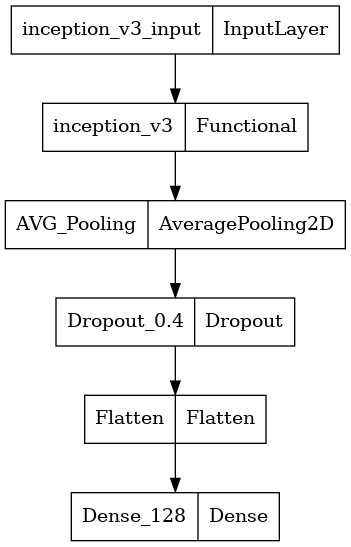

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_cnn, to_file='model_cnn.png')

In [ ]:
# Bert + LSTM text model
input_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name="input_word_ids")
input_masks = layers.Input(shape=(max_length,), dtype=tf.int32, name="input_masks")
input_segments = layers.Input(shape=(max_length,), dtype=tf.int32, name="segment_ids")
_, seq_out = bert_layer([input_ids, input_masks, input_segments])
out = layers.LSTM(128, name='LSTM')(seq_out)
model_lstm = models.Model([input_ids, input_masks, input_segments], out)

In [ ]:
# Keep the Bert + LSTM layers trainable
for layer in model_lstm.layers:
    layer.trainable = True

In [ ]:
model_lstm.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 512)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 512)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 1024),       335141889   ['input_word_ids[0][0]',         
                                 (None, 512, 1024)]               'input_masks[0][0]',        

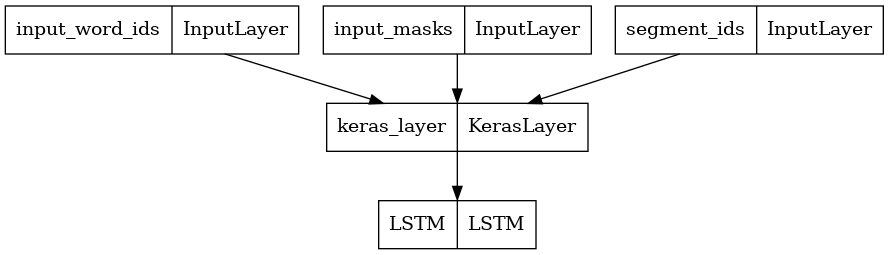

In [ ]:
plot_model(model_lstm, to_file='bert_lstm.png')

In [ ]:
# Stacking early-fusion multimodal model

input_word_ids = layers.Input(shape=(max_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = layers.Input(shape=(max_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = layers.Input(shape=(max_length,), dtype=tf.int32,
                                    name="segment_ids")
image_input = layers.Input(shape = input_shape, dtype=tf.float32,
                           name = "image")

image_side = model_cnn(image_input)
text_side = model_lstm([input_word_ids, input_mask, segment_ids])
# Concatenate features from images and texts
merged = layers.Concatenate()([image_side, text_side])
merged = layers.Dense(256, activation = 'relu')(merged)
output = layers.Dense(nClasses, activation='softmax', name = "class")(merged)

In [ ]:
model = models.Model([input_word_ids, input_mask, segment_ids, image_input], output)

In [ ]:
model.summary()

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='multimodal.png')

In [ ]:
# Stochastic Gradient Descent optimizer
sgd = optimizers.SGD(learning_rate=0.0001, momentum=0.9, nesterov=False)

# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [ ]:
# Setup callbacks, logs and early stopping condition
checkpoint_path = "stacking_early_fusion/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
cp = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy',save_best_only=True,verbose=1, mode='max')
csv_logger = callbacks.CSVLogger('stacking_early_fusion/stacking_early.log')
es = callbacks.EarlyStopping(patience = 3, restore_best_weights=True)

In [ ]:
# Reduce learning rate if no improvement is observed
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=1, min_lr=0.00001)

In [ ]:
# Load model weights
model.load_weights('stacking_early_fusion/weights-improvement-16-0.92.hdf5')

In [ ]:
# Training
history = model.fit(data_train,
                  epochs=15,
                  steps_per_epoch = train.shape[0]//batch_size,
                  validation_data = data_test,
                   validation_steps = test.shape[0]//batch_size,
                 callbacks=[cp, csv_logger, reduce_lr])

In [ ]:
# Plot training and test accuracy using Plotly library
df = pd.read_csv('stacking_early_fusion/stacking_early.log')

fig = go.Figure()
fig.add_trace(go.Scatter(x=df['epoch'], y=df['accuracy'],
                    mode='lines',
                    name='training'))

fig.add_trace(go.Scatter(x=df['epoch'], y=df['val_accuracy'],
                    mode='lines',
                    name='test'))

fig.update_layout(
    font_size = 20,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)

fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')

In [ ]:
# Plot training and test loss using Plotly library
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['epoch'], y=df['loss'],
                    mode='lines',
                    name='training'))

fig.add_trace(go.Scatter(x=df['epoch'], y=df['val_loss'],
                    mode='lines',
                    name='test'))

fig.update_layout(
    font_size = 20,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)

fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')

In [ ]:
# Model evaluation on test set
model.evaluate(data_test,
               steps = test.shape[0]//batch_size)

---

In [ ]:
# 아래 필요 x

In [ ]:
import re
import cv2
import tensorflow as tf
import numpy as np
from transformers import BertTokenizer

# BERT 토크나이저 준비
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 텍스트 전처리 함수
def preprocess_text(sen):
    # HTML 태그 제거
    sentence = remove_tags(sen)
    # 구두점과 숫자 제거
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # 단일 문자 제거
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # 여러 개의 공백 제거
    sentence = re.sub(r'\s+', ' ', sentence)
    sentence = sentence.lower()
    return sentence

# HTML 태그 제거 함수
def remove_tags(text):
    if isinstance(text, str):
        return TAG_RE.sub('', text)
    else:
        return ''


TAG_RE = re.compile(r'<[^>]+>')

# 이미지 로드 및 전처리 함수
def load_image(img_path):
    img = tf.io.read_file(img_path)  # 이미지 파일을 바이트 스트링으로 읽어옴
    img = tf.image.decode_jpeg(img, channels=3)  # JPEG 이미지를 디코딩하여 텐서로 변환
    img = tf.image.resize(img, (229, 229))  # 이미지 크기 조정
    img = img / 255.0  # 정규화
    return img



def create_dataset(df, batch_size):
    # 이미지 경로 추출
    image_paths = df['image_path'].values

    # 이미지 데이터셋 생성
    images = tf.data.Dataset.from_tensor_slices((df, image_paths))
    images = images.map(lambda x, y: load_image(x, y), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # 텍스트 데이터셋 생성
    texts = tf.data.Dataset.from_tensor_slices(df['Title'].values)

    # 데이터셋 병합
    dataset = tf.data.Dataset.zip((images, texts))
    dataset = dataset.batch(batch_size)

    return dataset


# 텍스트 전처리 및 BERT 입력 생성 함수
def prepare_text(texts, tokenizer, max_length):
    texts = [preprocess_text(text) for text in texts]
    input_ids = []
    attention_masks = []
    token_type_ids = []
    for text in texts:
        encoded_text = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='tf'
        )
        input_ids.append(encoded_text['input_ids'][0])
        attention_masks.append(encoded_text['attention_mask'][0])
        token_type_ids.append(encoded_text['token_type_ids'][0])
    return {
        'input_ids': np.array(input_ids),
        'attention_masks': np.array(attention_masks),
        'token_type_ids': np.array(token_type_ids)
    }

# 이미지와 텍스트 데이터를 로드하고 전처리하여 모델에 입력 형식으로 변환하는 함수
def prepare_data(image_paths, titles, labels):
    images = load_image(image_paths)
    texts = prepare_text(titles, tokenizer, max_length)
    return (images, texts), labels



def create_dataset(df, batch_size):
    # 이미지 경로 추출
    image_paths = df['image_path'].values

    # 이미지 데이터셋 생성
    images = tf.data.Dataset.from_tensor_slices(image_paths)
    images = images.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # 텍스트 데이터셋 생성
    texts = tf.data.Dataset.from_tensor_slices(df['Title'].values)
    texts = texts.map(preprocess_text, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # 레이블 데이터셋 생성
    labels = df['label_encode'].values

    # 데이터셋 병합
    dataset = tf.data.Dataset.zip((images, texts))
    dataset = dataset.map(lambda x, y: (x, y, labels))
    dataset = dataset.batch(batch_size)

    return dataset


In [ ]:
# 데이터셋 생성
batch_size = 16
dataset = create_dataset(sample_df, batch_size)

In [ ]:
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 229, 229, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 984), dtype=tf.int64, name=None))>

In [ ]:
ip, op, labels = next(iter(dataset))


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

# 이미지 입력 모델 (InceptionV3)
image_input = layers.Input(shape=(img_width, img_height, depth), name='image_input')
image_model = tf.keras.applications.InceptionV3(input_tensor=image_input, include_top=False, weights='imagenet')
image_model.trainable = False

# 텍스트 입력 모델 (BERT)
text_input = layers.Input(shape=(max_length,), dtype=tf.int32, name='text_input')
text_model = bert_layer([text_input['input_ids'], text_input['input_mask'], text_input['segment_ids']])[1]

# 모델 결합
combined_model = layers.concatenate([image_model.output, text_model])
combined_model = layers.Dense(512, activation='relu')(combined_model)
combined_model = layers.Dropout(0.5)(combined_model)
combined_model = layers.Dense(nClasses, activation='softmax')(combined_model)

# 최종 모델 정의
model = tf.keras.Model(inputs=[image_input, text_input], outputs=combined_model)

# 모델 컴파일
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
batch_size = 16
epochs = 10

dataset = create_dataset(sample_df, batch_size)

model.fit(dataset, epochs=epochs)
